In [9]:
# Compare how many more disk giant stars are there in APOGEE DR17
import astropy
from astropy.table import Table
import numpy as np
import pandas as pd
import h5py

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize, LogNorm
label_size = 24
matplotlib.rc('font', size=label_size) 

In [4]:
# Read in the data
parent_label_f = '../spec_download_norm/data/training_labels_parent_apogeedr17_edr3.fits'
print('loading labels...')
hdu = fits.open(parent_label_f)
labels = Table(hdu[1].data)
hdu.close()
print(f"Length of import labels: {len(labels)}")

loading labels...
Length of import labels: 123450


In [45]:
hdu = fits.open('../spec_download_norm/data/training_labels_new_N120309_lam0_K2_offset0.017_parallax_run1_poe27.fits')
labels0027 = Table(hdu[1].data)
hdu.close()

In [49]:
cut_specplx = labels0027['spec_parallax'] > 0.4+labels0027['parallax']

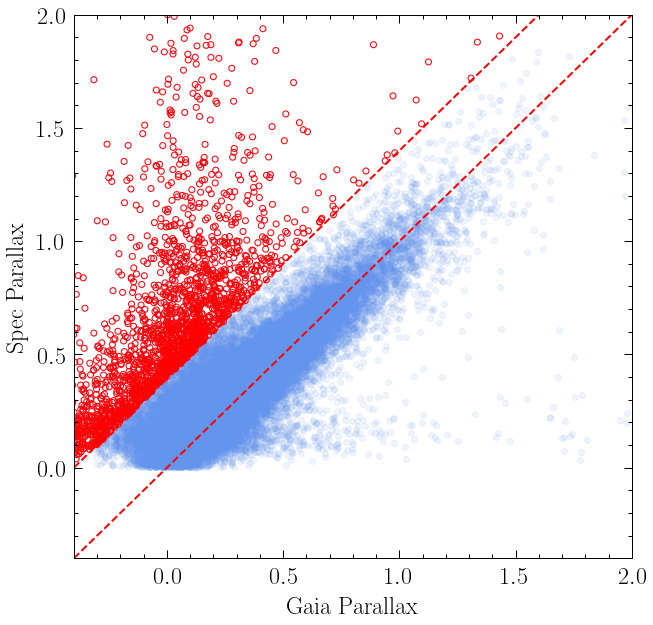

In [50]:
f = plt.figure(figsize=[10,10])

plt.scatter(labels0027['parallax'], labels0027['spec_parallax'], alpha=0.1)
plt.scatter(labels0027['parallax'][cut_specplx], labels0027['spec_parallax'][cut_specplx], alpha=1, fc='none', ec='r')
plt.plot([-0.4,2.0], [-0.4,2.0], 'r--')
plt.plot([-0.4,2.0], [0.,2.4], 'r--')
plt.xlabel('Gaia Parallax')
plt.ylabel('Spec Parallax')
plt.xlim([-0.4,2.0])
plt.ylim([-0.4,2.0])


plt.show()

In [56]:
# Check which of the following cut does the low parallax outliers fails (Note that they must have passed the color cuts to be included in the prediction sample)
print(f"Total stars with problematic parallaxes: {cut_specplx.sum()}")
print(f"fails finite plx cut: {(cut_specplx & ~(np.isfinite(labels['parallax']))).sum()}")
print(f"fails vis period cut: {(cut_specplx & ~(labels['visibility_periods_used'] >= 8)).sum()}")
print(f"fails plx error cut: {(cut_specplx & ~(labels['parallax_error'] < 0.1)).sum()}")
print(f"fails astrometric cut: {(cut_specplx & ~((labels['astrometric_chi2_al'] / np.sqrt(labels['astrometric_n_good_obs_al']-5)) <= 35)).sum()}")

Total stars with problematic parallaxes: 2389
fails finite plx cut: 0
fails vis period cut: 0
fails plx error cut: 1122
fails astrometric cut: 1809


In [57]:
# Check is a random sample of the same size fails the same amount of cut
rand_tmp = np.random.choice(len(labels),cut_specplx.sum(),replace=False)
cut_rand = np.zeros(len(labels),dtype=bool)
cut_rand[rand_tmp] = True
print(f"Total random stars: {cut_rand.sum()}")
print(f"fails finite plx cut: {(cut_rand & ~(np.isfinite(labels['parallax']))).sum()}")
print(f"fails vis period cut: {(cut_rand & ~(labels['visibility_periods_used'] >= 8)).sum()}")
print(f"fails plx error cut: {(cut_rand & ~(labels['parallax_error'] < 0.1)).sum()}")
print(f"fails astrometric cut: {(cut_rand & ~((labels['astrometric_chi2_al'] / np.sqrt(labels['astrometric_n_good_obs_al']-5)) <= 35)).sum()}")

Total random stars: 2389
fails finite plx cut: 0
fails vis period cut: 0
fails plx error cut: 90
fails astrometric cut: 668


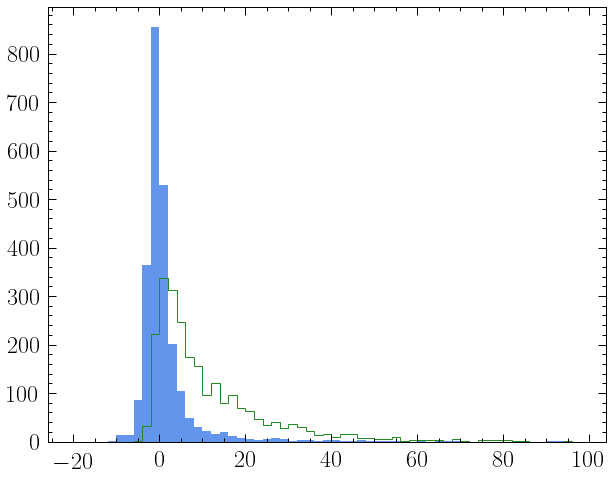

In [61]:
f = plt.figure(figsize=[10,8])
plt.hist(labels0027['parallax_over_error'][cut_specplx],bins=np.arange(-20,100,2))
plt.hist(labels0027['parallax_over_error'][cut_rand],bins=np.arange(-20,100,2),histtype='step')
plt.show()

In [5]:
cut_jk = (labels['J'] - labels['K']) < (0.4 + 0.45 * labels['bp_rp'])
cut_hw2 = (labels['H'] - labels['w2mpro']) > -0.05
cut_finite = (labels['J'] > -100) * (labels['H'] > -100) * (labels['K'] > -100) *\
             (labels['J'] < 90) * (labels['H'] < 90) * (labels['K'] < 90) *\
             (labels['J_ERR'] > 0) * (labels['H_ERR'] > 0) * (labels['K_ERR'] > 0) * \
             np.isfinite(labels['w1mpro']) * np.isfinite(labels['w2mpro']) * \
             (labels['w1mpro_error'] > 0) * (labels['w2mpro_error'] > 0)
labels = labels[cut_jk * cut_hw2 * cut_finite]
# labels = labels[cut_jk * cut_hw2 * cut_finite * cut_negplx]
print(f"Length of import labels after color cuts: {len(labels)}")

Length of import labels after color cuts: 120309


/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [8]:
labels.colnames

['apogee_id',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'bp_rp',
 'phot_g_mean_flux',
 'phot_bp_mean_flux',
 'phot_rp_mean_flux',
 'phot_g_mean_flux_error',
 'phot_bp_mean_flux_error',
 'phot_rp_mean_flux_error',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'visibility_periods_used',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_n_good_obs_al',
 'source_id',
 'original_ext_source_id',
 'angular_distance',
 'xm_flag',
 'allwise_oid',
 'number_of_neighbours',
 'number_of_mates',
 'designation',
 'w1mpro',
 'w2mpro',
 'w1mpro_error',
 'w2mpro_error',
 'APOGEE_ID',
 'LOGG',
 'J',
 'H',
 'K',
 'J_ERR',
 'H_ERR',
 'K_ERR',
 'EXTRATARG',
 'GAIAEDR3_SOURCE_ID',
 'TELESCOPE',
 'FIELD',
 'FILE']

In [15]:
np.random.seed(1)
random_vector = np.random.choice(2, (len(labels),))
k = 0
valid = random_vector == k
train = np.logical_not(valid)
print('k = {0}: # of stars for prediction: {1}'.format(k, sum(valid)))
print('k = {0}: # of remaining of stars: {1}'.format(k, sum(train)))

k = 0: # of stars for prediction: 60411
k = 0: # of remaining of stars: 59898


In [24]:
# finite parallax required for training
cut_parallax = np.isfinite(labels[train]['parallax'])

# visibility periods used
cut_vis = labels[train]['visibility_periods_used'] >= 8

# cut in parallax_error
cut_par = labels[train]['parallax_error'] < 0.1       # this cut is not strictly required!
cut_burnin = labels[train]['parallax_over_error'] > 20. # XO note: This is necessary for the first fit to avoid the false optimum.
burnins_poe = [40., 30., 27., 25., 0.]

# cut in astrometric_gof_al (should be around unity...?) *Daniel Michalik's advice*
#cut_gof = labels[train]['astrometric_gof_al'] < 5  
# Coryn's advice!
cut_cal = (labels[train]['astrometric_chi2_al'] / np.sqrt(labels[train]['astrometric_n_good_obs_al']-5)) <= 35         

# more cuts? e.g. astrometric_gof_al should be low!
cut_all = cut_parallax * cut_vis * cut_par * cut_cal * (labels[train]['parallax_over_error'] > 27)
print('k = {0}: # of stars in training set: {1}'.format(k, len(labels[train][cut_all])))

k = 0: # of stars in training set: 3110


In [34]:
cut_25_27 = cut_parallax * cut_vis * cut_par * cut_cal * (labels[train]['parallax_over_error'] > 25) * (labels[train]['parallax_over_error'] < 27)
print(len(labels[train][cut_25_27]))

546


array([False, False, False, ..., False, False, False])

In [31]:
# indices of the stars in the training half added when poe cut drop from 27 to 25
ind_25_27 = np.arange(123450)[cut_jk * cut_hw2 * cut_finite][train][cut_25_27]

In [64]:
# My cut(?)
cut_hw2add = (labels['H'] - labels['w2mpro']) < (0.05 + 0.27 * labels['bp_rp'])
print((~cut_hw2add).sum())

294


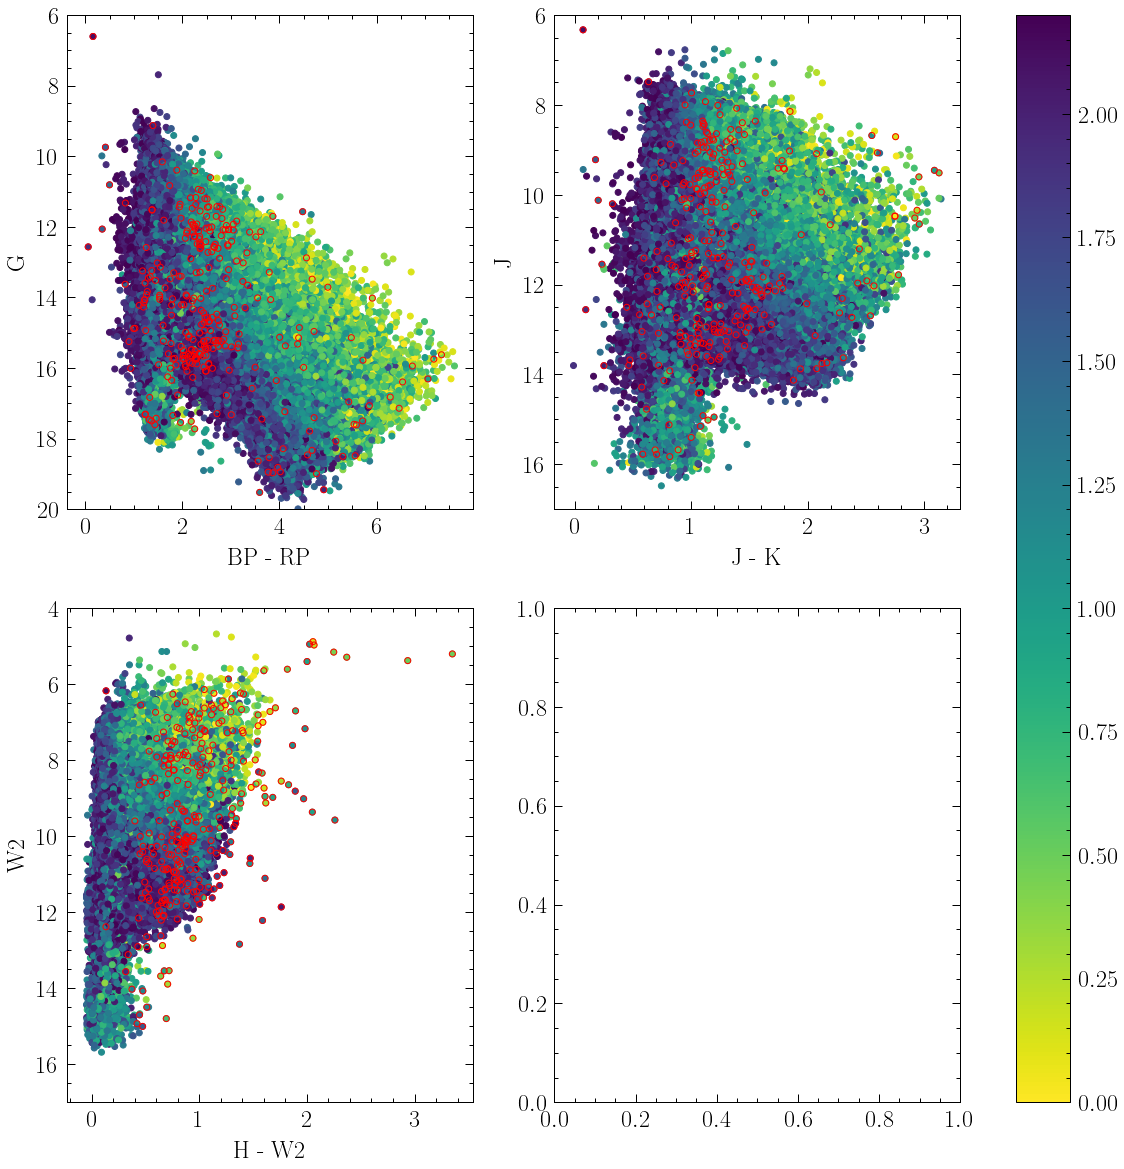

In [70]:
# Make the color color diagram
f, axs = plt.subplots(2,2,figsize=[20,20])

im = axs[0,0].scatter(labels['phot_bp_mean_mag']-labels['phot_rp_mean_mag'], labels['phot_g_mean_mag'], c=labels['LOGG'], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[0,0].scatter(labels['phot_bp_mean_mag'][~cut_hw2add]-labels['phot_rp_mean_mag'][~cut_hw2add], labels['phot_g_mean_mag'][~cut_hw2add], fc='none', ec='r')
axs[0,0].set_xlabel('BP - RP')
axs[0,0].set_ylabel('G')
# axs[0,0].set_xlim([0,6])
axs[0,0].set_ylim([20,6])

axs[0,1].scatter(labels['J']-labels['K'], labels['J'], c=labels['LOGG'], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[0,1].scatter(labels['J'][~cut_hw2add]-labels['K'][~cut_hw2add], labels['J'][~cut_hw2add], fc='none', ec='r')
axs[0,1].set_xlabel('J - K')
axs[0,1].set_ylabel('J')
# axs[0,1].set_xlim([0,6])
axs[0,1].set_ylim([17,6])

axs[1,0].scatter(labels['H']-labels['w2mpro'], labels['w2mpro'], c=labels['LOGG'], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[1,0].scatter(labels['H'][~cut_hw2add]-labels['w2mpro'][~cut_hw2add], labels['w2mpro'][~cut_hw2add], fc='none', ec='r')
axs[1,0].set_xlabel('H - W2')
axs[1,0].set_ylabel('W2')
# axs[1,0].set_xlim([0,6])
axs[1,0].set_ylim([17,4])

cb = f.colorbar(im, ax=axs)

plt.show()

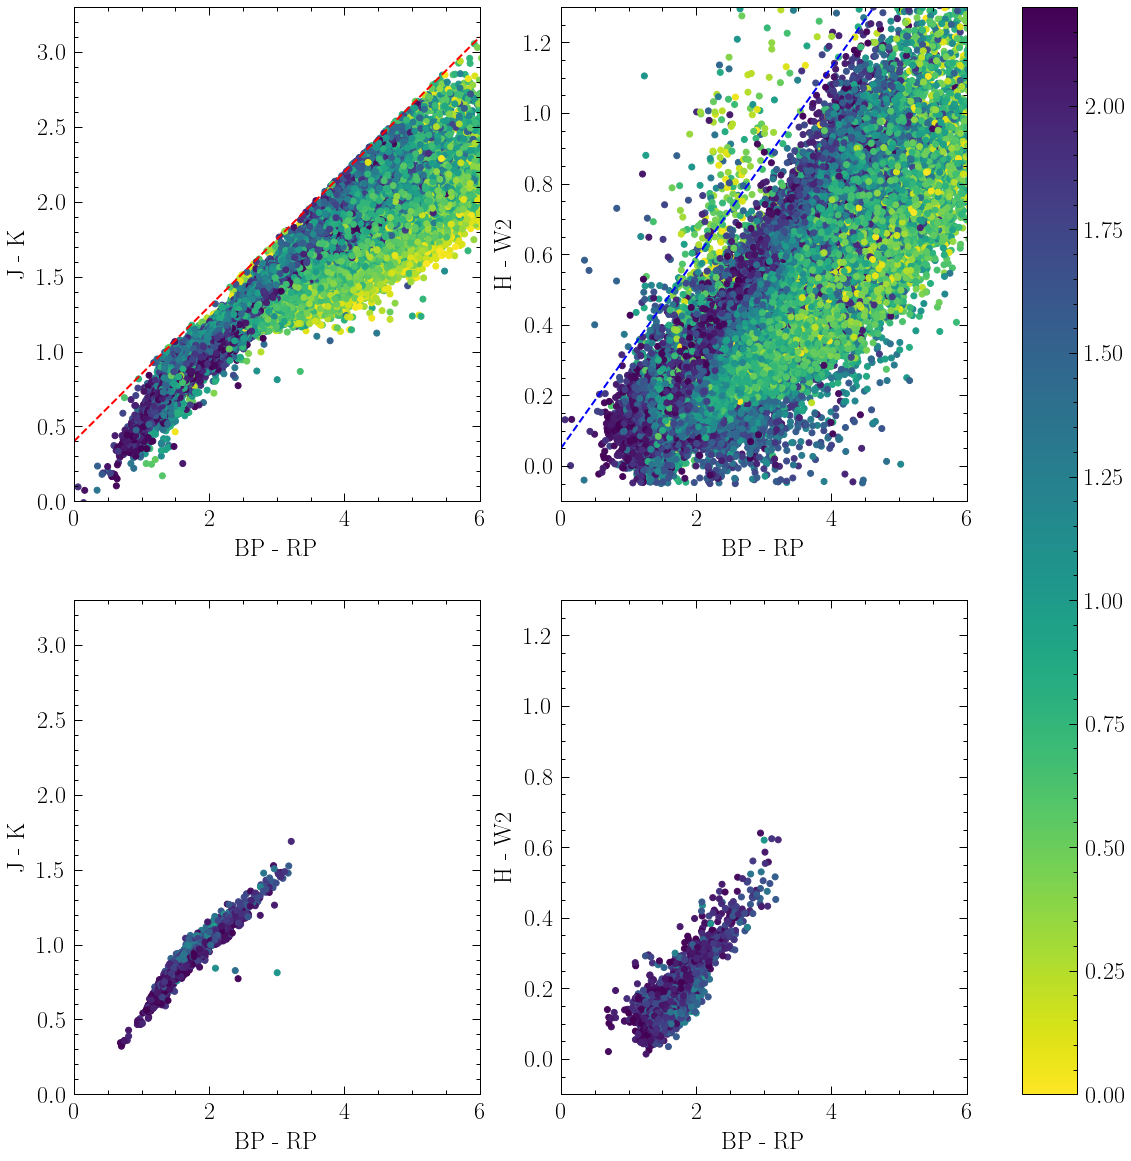

In [63]:
# Make the color color diagram
f, axs = plt.subplots(2,2,figsize=[20,20])

im = axs[0,0].scatter(labels['phot_bp_mean_mag']-labels['phot_rp_mean_mag'], labels['J']-labels['K'], c=labels['LOGG'], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[0,0].plot([0,6], [0.4, 0.4+0.45*6], 'r--')
axs[0,0].set_xlabel('BP - RP')
axs[0,0].set_ylabel('J - K')
axs[0,0].set_xlim([0,6])
axs[0,0].set_ylim([0,3.3])

axs[0,1].scatter(labels['phot_bp_mean_mag']-labels['phot_rp_mean_mag'], labels['H']-labels['w2mpro'], c=labels['LOGG'], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[0,1].plot([0,6], [0.05, 0.05+0.27*6], 'b--')
axs[0,1].set_xlabel('BP - RP')
axs[0,1].set_ylabel('H - W2')
axs[0,1].set_xlim([0,6])
axs[0,1].set_ylim([-0.1,1.3])


selec = train
axs[1,0].scatter(labels['phot_bp_mean_mag'][selec][cut_all]-labels['phot_rp_mean_mag'][selec][cut_all], labels['J'][selec][cut_all]-labels['K'][selec][cut_all], 
                 c=labels['LOGG'][selec][cut_all], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[1,0].set_xlabel('BP - RP')
axs[1,0].set_ylabel('J - K')
axs[1,0].set_xlim([0,6])
axs[1,0].set_ylim([0,3.3])

axs[1,1].scatter(labels['phot_bp_mean_mag'][selec][cut_all]-labels['phot_rp_mean_mag'][selec][cut_all], labels['H'][selec][cut_all]-labels['w2mpro'][selec][cut_all], 
                 c=labels['LOGG'][selec][cut_all], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[1,1].set_xlabel('BP - RP')
axs[1,1].set_ylabel('H - W2')
axs[1,1].set_xlim([0,6])
axs[1,1].set_ylim([-0.1,1.3])


cb = f.colorbar(im, ax=axs)

plt.show()

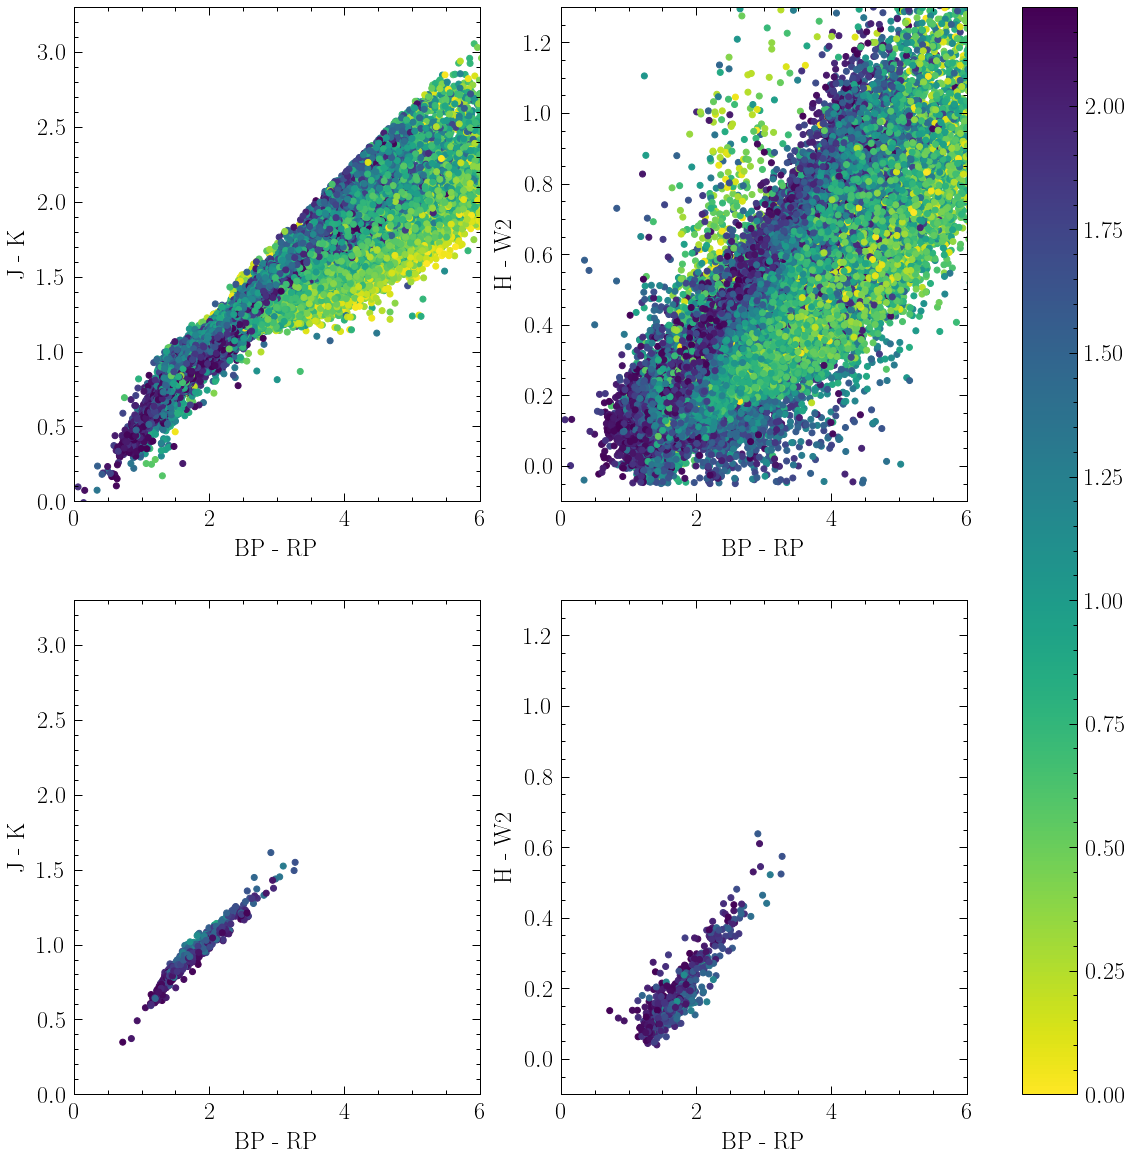

In [39]:
# Make the color color diagram
f, axs = plt.subplots(2,2,figsize=[20,20])

im = axs[0,0].scatter(labels['phot_bp_mean_mag']-labels['phot_rp_mean_mag'], labels['J']-labels['K'], c=labels['LOGG'], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[0,0].set_xlabel('BP - RP')
axs[0,0].set_ylabel('J - K')
axs[0,0].set_xlim([0,6])
axs[0,0].set_ylim([0,3.3])

axs[0,1].scatter(labels['phot_bp_mean_mag']-labels['phot_rp_mean_mag'], labels['H']-labels['w2mpro'], c=labels['LOGG'], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[0,1].set_xlabel('BP - RP')
axs[0,1].set_ylabel('H - W2')
axs[0,1].set_xlim([0,6])
axs[0,1].set_ylim([-0.1,1.3])


selec = train
selec_cut = cut_25_27
axs[1,0].scatter(labels['phot_bp_mean_mag'][selec][selec_cut]-labels['phot_rp_mean_mag'][selec][selec_cut], labels['J'][selec][selec_cut]-labels['K'][selec][selec_cut], 
                 c=labels['LOGG'][selec][selec_cut], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[1,0].set_xlabel('BP - RP')
axs[1,0].set_ylabel('J - K')
axs[1,0].set_xlim([0,6])
axs[1,0].set_ylim([0,3.3])

axs[1,1].scatter(labels['phot_bp_mean_mag'][selec][selec_cut]-labels['phot_rp_mean_mag'][selec][selec_cut], labels['H'][selec][selec_cut]-labels['w2mpro'][selec][selec_cut], 
                 c=labels['LOGG'][selec][selec_cut], norm=Normalize(vmin=0,vmax=2.2), cmap='viridis_r')
axs[1,1].set_xlabel('BP - RP')
axs[1,1].set_ylabel('H - W2')
axs[1,1].set_xlim([0,6])
axs[1,1].set_ylim([-0.1,1.3])


cb = f.colorbar(im, ax=axs)

plt.show()